# Evaluation of Relative Quantification with OpenMS

- Author: Louis Felix Nothias, University of California San Diego, louisfelix.nothias@gmail.com
- Env: Python 2.7.15

**Summary**: In this notebook we will compute the R-squared (coefficient of determination) of ordinary least squares Linear regression for Feature-Based Molecular Networking (FBMN).

**Steps**: 
- We are starting from an feature quantification table from FBMN (here obtained from MZmine), and Classical MN tables (scan-based and bucket table).
- We are formating the table and merging with metadata (annotations), 
- We filter for annotations that are validated in the NIST SRM sample.
- No normalization is applied here. We used replicates.
- We perform linear regression analysis and some filtering.
- We plot the results for all or annotated with FBMN or classical MN

**Note**: I am new to python, so please forgive if the code lacks of elegance.

## Import and print modules version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# Print modules version from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import types

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

excludes = ['builtins', 'types', 'sys']

imported_modules = [module for module in imports() if module not in excludes]

clean_modules = []

for module in imported_modules:

    sep = '.'  # to handle 'matplotlib.pyplot' cases
    rest = module.split(sep, 1)[0]
    clean_modules.append(rest)

changed_imported_modules = list(set(clean_modules))  # drop duplicates

pip_modules = !pip freeze  # you could also use `!conda list` with anaconda

for module in pip_modules:
    name, version = module.split('==')
    if name in changed_imported_modules:
        print(name + '\t' + version)

matplotlib	2.2.2
numpy	1.16.3
pandas	0.23.3
seaborn	0.9.0


## Define the path to FBMN, classical MN, and metadata tables

In [3]:
#Open the feature quantification table

#OpenMS quant 2001 QT Aligner
FBMN_filename = 'Input_files/OpenMS_job_2001_QT/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-53bcfa39-download_cytoscape_data/quantification_table_reformatted/e8d27658d164497c8a51b0bd121ecce1.csv'
gnps_table = pd.read_table('Input_files/OpenMS_job_2001_QT/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-53bcfa39-download_cytoscape_data/DB_result/f04cf74f2fcf409d9cc70497b4b7fdf2.tsv')
    
#OpenMS quant 2001 KT Aligner
#FBMN_filename = 'Input_files/OpenMS_job_2001_KD/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-fdaa55d8-download_cytoscape_data/quantification_table_reformatted/9ac8d75bccf14fb79785deec3e613233.csv'
#gnps_table = pd.read_table('Input_files/OpenMS_job_2001_KD/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-fdaa55d8-download_cytoscape_data/DB_result/660fb0e1306c41fc8e97289e0c5c3100.tsv')
    
#MS-Cluster job (https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=daf3f0d7cec94104b2c9001739964c31)
classicalMN_bucketable_filename = 'Input_files/MSCluster_job_v1/ProteoSAFe-METABOLOMICS-SNETS-V2-daf3f0d7-download_cluster_buckettable/METABOLOMICS-SNETS-V2-daf3f0d7-download_cluster_buckettable-main.tsv'
classicalMN_scans_filename = 'Input_files/MSCluster_job_v1/ProteoSAFe-METABOLOMICS-SNETS-V2-daf3f0d7-download_cytoscape_data/clusterinfosummarygroup_attributes_withIDs_withcomponentID/f7952c5edf9e4afe80dcf7b314b1cfec.txt'

#Define metadata filename
metadata_filename = 'Input_files/Metadata/FeatureBasedMolecularNetworking_NIST_QE.txt'

validated = pd.read_table('Input_files/Metadata/QE_NIST_1950SRM_Annotations_validated.txt',
                          index_col=None, header=0, sep='\t')

### Prepare FBMN table

In [4]:
# Read FBMN feature table
ft = pd.read_table(FBMN_filename, index_col=None, header=None, sep=',')
ft.head(3)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,row ID,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,L_C18_Polar_16_Blk_no_inj_02.mzML Peak area,L_C18_Polar_16_Blk_no_inj_04.mzML Peak area,L_C18_Polar_16_Blk_no_inj_06.mzML Peak area,L_C18_Polar_16_Blk_no_inj_08.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area
1,1,102.03371458804199,780.5887957121299,742765312.0,771211072.0,814968512.0,733418688.0,796707968.0,837682688.0,670616832.0,...,926253120.0,894505984.0,676498688.0,673392768.0,623772032.0,741099520.0,814899904.0,812199168.0,760554880.0,751545472.0
2,2,290.268067533111,370.81648761996803,5230193.0,4465598.0,4251535.0,3945531.0,4303219.0,4059550.0,4311076.0,...,2638717.0,2742417.0,4117208.0,3291945.0,3902551.0,4238378.0,4653135.0,4362547.0,4009156.0,4037313.0


In [5]:
# Prepare the FBMN feature quantification table
new_header = ft.iloc[0] #grab the first row for the header
ft = ft[1:] #take the data less the header row
ft.columns = new_header #set the header row as the df header
# Set to float
ft['row m/z'] = ft['row m/z'].astype(float)
ft['row retention time'] = ft['row retention time'].astype(float)

# Set decimal number and apply lambda function
desred_decimals = 4    
ft['row m/z'] = ft['row m/z'].apply(lambda x: round(x,desred_decimals))
desred_decimals = 2    
ft['row retention time'] = ft['row retention time'].apply(lambda x: round(x,desred_decimals))
ft.head(5)

# Copy the table and change back to str to join them in a new column
ft2 = ft
ft2['row ID'] = ft['row ID'].astype(str)
ft2['row m/z'] = ft['row m/z'].astype(str)
ft2['row retention time'] = ft['row retention time'].astype(str)
# Create a unique ID
ft2['ID'] = ft2[['row m/z','row retention time','row ID']].apply(lambda x: '_'.join(x), axis=1)
ft2.head(3)

,row ID,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,L_C18_Polar_16_Blk_no_inj_04.mzML Peak area,L_C18_Polar_16_Blk_no_inj_06.mzML Peak area,L_C18_Polar_16_Blk_no_inj_08.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,ID
1,1,102.0337,780.59,742765312.0,771211072.0,814968512.0,733418688.0,796707968.0,837682688.0,670616832.0,...,894505984.0,676498688.0,673392768.0,623772032.0,741099520.0,814899904.0,812199168.0,760554880.0,751545472.0,102.0337_780.59_1
2,2,290.2681,370.82,5230193.0,4465598.0,4251535.0,3945531.0,4303219.0,4059550.0,4311076.0,...,2742417.0,4117208.0,3291945.0,3902551.0,4238378.0,4653135.0,4362547.0,4009156.0,4037313.0,290.2681_370.82_2
3,3,230.2475,368.38,6781410.0,6968077.0,5577357.0,9677228.0,10913030.0,8551338.0,10236170.0,...,5933953.0,6991384.0,8115280.0,7227486.0,9768155.0,946866.0,6513192.0,7748502.0,855225.0,230.2475_368.38_3


In [6]:
gnps_table_mscluster = pd.read_table(classicalMN_scans_filename, index_col=None, header=0, sep='\t')
classicalMN_bucketable = pd.read_table(classicalMN_bucketable_filename, index_col=None, header=0, sep='\t') #skipows=1 

### Prepare the annotations and get informations

In [7]:
#Import the validated annotations
validated_annotation = validated[validated['Validation'].str.contains('YES',na=False)]
validated_annotation_list=set(validated_annotation['Compound_Name'])

#Import GNPS DB-results for Feature Based Molecular Networking
gnps_table = pd.read_table('Input_files/MZmine2_job_v4_2iso/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-b9c75ead-download_cytoscape_data/DB_result/0b01b0bbab80468283de9e876edc9c28.tsv')
gnps_table = gnps_table.set_index(['#Scan#'])
new_names = [(i,'GNPS_'+i) for i in gnps_table.iloc[:, 0:].columns.values]
gnps_table.rename(columns = dict(new_names), inplace=True)

unique_FBMN_annotations = set(gnps_table['GNPS_Compound_Name'])

#Filter annotations for Classical MN
gnps_table_mscluster2 = gnps_table_mscluster.dropna(subset=['LibraryID'])

#Make the sets:
a=set(gnps_table['GNPS_Compound_Name']) #FBMN
b=set(gnps_table_mscluster2['LibraryID']) #Classical MN
#Intersection
x = a.intersection(b)

##### FBMN
#Filter the table for FBMN
gnps_table_ft2 = gnps_table
gnps_table_ft_set = gnps_table_ft2[gnps_table_ft2.GNPS_Compound_Name.isin(x)]

#Keep only the validated annotation 
gnps_table_ft_set = gnps_table_ft_set[gnps_table_ft_set.GNPS_Compound_Name.isin(validated_annotation_list)]
gnps_table_ft_set_validated = gnps_table_ft_set

#### CLASSICAL MN SCANS
#Number of validated annotations in Classical MN
gnps_table_ms_cluster_validated = gnps_table_mscluster2[gnps_table_mscluster2.LibraryID.isin(x)]
gnps_table_ms_cluster_set = gnps_table_ms_cluster_validated[gnps_table_ms_cluster_validated.LibraryID.isin(validated_annotation_list)]

df7 = gnps_table_ms_cluster_validated
gnps_table2 = gnps_table_ms_cluster_validated


# Get the unique values in the filtered table (shared annotations only)
a1=set(gnps_table_ft_set_validated['GNPS_Compound_Name'])
a2=set(gnps_table_ms_cluster_set['LibraryID'])

print('======= Feature based MN ========')
print('Number of annotations in FBMN')
print(validated.shape[0])

print('Number of unique annotations in FBMN')
print(len(unique_FBMN_annotations))

print('Number of unique validated compounds in FBMN')
print(len(validated_annotation_list))

print('======= MS-Cluster based MN ========')

print('Number of annotation in classical MN')
print(len(gnps_table_mscluster2['LibraryID']))
print('Number of validated annotations in classical MN')
print(len(b))

print('Number of validated unique annotations in classical MN')
print(len(set(gnps_table_ms_cluster_set)))

print('======= Shared between FBMN and classical MN ========')

print('Number of validated annotations shared between FBMN and classical MN')
print(gnps_table_ft_set.shape[0])

print('Number of validated unique annotations shared between FBMN and classical MN')
print(len(a1))

======= Feature based MN ========
Number of annotations in FBMN
220
Number of unique annotations in FBMN
161
Number of unique validated compounds in FBMN
51
======= MS-Cluster based MN ========
Number of annotation in classical MN
313
Number of validated annotations in classical MN
223
Number of validated unique annotations in classical MN
57
======= Shared between FBMN and classical MN ========
Number of validated annotations shared between FBMN and classical MN
61
Number of validated unique annotations shared between FBMN and classical MN
40


### Merge feature quantification table and feature metadata

In [8]:
# Merge the metadata and ft2 (FBMN)
# Here the columns has to be from the 
ftX = ft2
ftX.rename(columns={"row ID":'#Scan#'}, inplace=True)
ftX['#Scan#'] = ftX['#Scan#'].astype(int)
#ftX = ftX.set_index('#Scan#')
ftX[[ 'L_C18_Polar_16_MS2_DF_1_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_03.mzML Peak area','ID']] = ftX[['L_C18_Polar_16_MS2_DF_1_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_03.mzML Peak area','ID']]

# Merge with all the features
ft2_all = ftX.merge(gnps_table, on=['#Scan#'], how='outer')
ft2_all.head(3)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,1,102.0337,780.59,742765312.0,771211072.0,814968512.0,733418688.0,796707968.0,837682688.0,670616832.0,...,0.0,5.0,C1CCC2=NCCCN2CC1,1.0,153.138,spectra/specs_ms.mgf,CCMSLIB00003265542,76800.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,2,290.2681,370.82,5230193.0,4465598.0,4251535.0,3945531.0,4303219.0,4059550.0,4311076.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,230.2475,368.38,6781410.0,6968077.0,5577357.0,9677228.0,10913030.0,8551338.0,10236170.0,...,0.0,11.0,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,1.0,311.080,spectra/specs_ms.mgf,CCMSLIB00003199179,31210000.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


In [9]:
## Merge with annotated features
ft2_id = ftX.merge(gnps_table_ft_set_validated, on=['#Scan#'], how='inner')
print(ft2_id.shape)
#Filter feature below 10 ppm
ft2_id = ft2_id.loc[ft2_id['GNPS_MZErrorPPM'] < 5 ]
ft2_id
print(ft2_id.shape)
ft2_id.head(2)

(61, 58)
(61, 58)


,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,8,302.3043,399.31,1637124.0,1150960.0,9843772.0,11124140.0,1418050.0,1484570.0,1251566.0,...,0,6,C[N+](C)(C)CC(CC(=O)[O-])O,1,162.112,spectra/specs_ms.mgf,CCMSLIB00003446005,19920000.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,32,782.5664,745.56,46867768.0,111018400.0,90383800.0,6427834.0,0.0,10424310.0,0.0,...,0,7,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,1,204.123,spectra/specs_ms.mgf,CCMSLIB00003280031,71382000.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


In [10]:
#disabled to test
#ft2_id = ftX.merge(gnps_table_ft_set, on=['#Scan#'], how='inner')

In [11]:
#check the size of 
print(ft2.shape)
print(ft2_id.shape)

(1025, 23)
(61, 58)


### Prepare metadata table

In [12]:
#import the metadata table
metadata = pd.read_table(metadata_filename, low_memory=False, index_col=None, header=0, sep='\t',
                         dtype=str)
a = metadata.shape[1]
metadata.head(5)

# Set the minimum concentration if needed.
print(metadata.shape)
metadata['Concentration'] = metadata['Concentration'].astype(float)
metadata = metadata.loc[metadata['Concentration'] > 0.00001]
print(metadata.shape)

(19, 6)
(15, 6)


In [13]:
ft2.head(2)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,L_C18_Polar_16_Blk_no_inj_04.mzML Peak area,L_C18_Polar_16_Blk_no_inj_06.mzML Peak area,L_C18_Polar_16_Blk_no_inj_08.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,ID
1,1,102.0337,780.59,742765312.0,771211072.0,814968512.0,733418688.0,796707968.0,837682688.0,670616832.0,...,894505984.0,676498688.0,673392768.0,623772032.0,741099520.0,814899904.0,812199168.0,760554880.0,751545472.0,102.0337_780.59_1
2,2,290.2681,370.82,5230193.0,4465598.0,4251535.0,3945531.0,4303219.0,4059550.0,4311076.0,...,2742417.0,4117208.0,3291945.0,3902551.0,4238378.0,4653135.0,4362547.0,4009156.0,4037313.0,290.2681_370.82_2


### Merge with metadata table for all the features

In [14]:
#Check the other table
ft2_all.head(2)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,1,102.0337,780.59,742765312.0,771211072.0,814968512.0,733418688.0,796707968.0,837682688.0,670616832.0,...,0.0,5.0,C1CCC2=NCCCN2CC1,1.0,153.138,spectra/specs_ms.mgf,CCMSLIB00003265542,76800.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,2,290.2681,370.82,5230193.0,4465598.0,4251535.0,3945531.0,4303219.0,4059550.0,4311076.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Tranpose the table to facilitate cleaning
ft2 = ft2.T
ft3 = ft2.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
ft3[0] = ft3[0].str.replace(' Peak area', '') ## Leave the empty space before Peak area

ft3.set_index(0)

# Redefine the index with ID row
ft3.columns = ft3.iloc[(ft3.shape[0])-1]
ft3.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3.head(3)

22,#SampleID,102.0337_780.59_1,290.2681_370.82_2,230.2475_368.38_3,125.9861_782.61_4,776.2317_653.38_5,311.0798_310.57_6,167.0126_781.47_7,302.3043_399.31_8,399.2501_481.79_9,...,820.6282_584.9_1016,909.5467_769.97_1017,771.5728_766.19_1018,407.7557_771.63_1019,636.6284_661.47_1020,877.7244_683.84_1021,420.7637_768.35_1022,502.2919_770.15_1023,898.785_732.6_1024,498.9003_764.93_1025
0,#Scan#,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025
1,row m/z,102.0337,290.2681,230.2475,125.9861,776.2317,311.0798,167.0126,302.3043,399.2501,...,820.6282,909.5467,771.5728,407.7557,636.6284,877.7244,420.7637,502.2919,898.785,498.9003
2,row retention time,780.59,370.82,368.38,782.61,653.38,310.57,781.47,399.31,481.79,...,584.9,769.97,766.19,771.63,661.47,683.84,768.35,770.15,732.6,764.93


In [16]:
# Tranpose the table to facilitate cleaning

ft3.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3_ID = ft3
ft3.shape

(23, 1026)

In [17]:
#metadata.head(2)
#ft3.columns = ft3.iloc[680]
print(metadata.shape)
metadata.rename(columns={'filename':'#SampleID'}, inplace=True)
print(metadata.shape)
metadata.head(10)

(15, 6)
(15, 6)


,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column
4,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,1,C18_Polar_16
5,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,2,C18_Polar_16
6,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,3,C18_Polar_16
7,L_C18_Polar_16_MS2_DF_125_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,1,C18_Polar_16
8,L_C18_Polar_16_MS2_DF_125_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,2,C18_Polar_16
9,L_C18_Polar_16_MS2_DF_125_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,3,C18_Polar_16
10,L_C18_Polar_16_MS2_DF_25_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,1,C18_Polar_16
11,L_C18_Polar_16_MS2_DF_25_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,2,C18_Polar_16
12,L_C18_Polar_16_MS2_DF_25_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,3,C18_Polar_16
13,L_C18_Polar_16_MS2_DF_5_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.200,5,1,C18_Polar_16


In [18]:
# Merge the metadata and ft2
dfa = pd.merge(metadata,ft3, on=['#SampleID'], how='right') # pd.concat()
dfa = dfa.loc[dfa.Dilution.notnull()]
print(dfa.shape)
dfa.head(15)

(15, 1031)


,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,102.0337_780.59_1,290.2681_370.82_2,230.2475_368.38_3,125.9861_782.61_4,...,820.6282_584.9_1016,909.5467_769.97_1017,771.5728_766.19_1018,407.7557_771.63_1019,636.6284_661.47_1020,877.7244_683.84_1021,420.7637_768.35_1022,502.2919_770.15_1023,898.785_732.6_1024,498.9003_764.93_1025
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0000,1,1,C18_Polar_16,742765312.0,5230193.0,6781410.0,220250208.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0000,1,2,C18_Polar_16,771211072.0,4465598.0,6968077.0,247082096.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0000,1,3,C18_Polar_16,814968512.0,4251535.0,5577357.0,267915392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,L_C18_Polar_16_MS2_DF_125_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0080,125,1,C18_Polar_16,751545472.0,4037313.0,855225.0,246018800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7258589.0
4,L_C18_Polar_16_MS2_DF_125_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0080,125,2,C18_Polar_16,760554880.0,4009156.0,7748502.0,253217104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,L_C18_Polar_16_MS2_DF_125_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0080,125,3,C18_Polar_16,812199168.0,4362547.0,6513192.0,269677696.0,...,0.0,0.0,0.0,0.0,0.0,17886760.0,940718.6875,4943717.0,13393090.0,0.0
6,L_C18_Polar_16_MS2_DF_25_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0400,25,1,C18_Polar_16,796707968.0,4303219.0,10913030.0,249745792.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,L_C18_Polar_16_MS2_DF_25_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0400,25,2,C18_Polar_16,733418688.0,3945531.0,9677228.0,242192992.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,L_C18_Polar_16_MS2_DF_25_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.0400,25,3,C18_Polar_16,837682688.0,4059550.0,8551338.0,279399392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,L_C18_Polar_16_MS2_DF_5_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.2000,5,1,C18_Polar_16,670616832.0,4311076.0,10236170.0,217375696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merge with metadata table for the annotated features

In [19]:
# Tranpose the table to facilitate cleaning
ft2_id2 = ft2_id.T
ft3id = ft2_id2.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
ft3id['index'] = ft3id['index'].str.replace(' Peak area', '') ## Leave the empty space before Peak area
print(ft3id.shape)
#ft3id.set_index(0)

# Redefine the index with ID row
ft3id.columns = ft3id.iloc[(ft3id.shape[0])-36]
ft3id.rename(columns={'ID':'#SampleID'}, inplace=True)
print(ft3id.shape)
ft3id.head(5)

(58, 62)
(58, 62)


22,#SampleID,302.3043_399.31_8,782.5664_745.56_32,227.1752_98.71_62,110.0711_765.84_70,247.166_765.68_81,338.341_623.14_85,132.0766_19.15_89,536.1645_675.15_112,186.9804_768.58_115,...,148.5642_281.46_705,316.3201_767.09_734,239.1638_460.81_764,305.1561_199.18_770,266.6083_438.51_783,178.5605_208.34_792,1001.6543_460.44_805,689.5583_770.5_823,414.7793_772.28_881,578.2764_427.82_988
0,#Scan#,8,32,62,70,81,85,89,112,115,...,705,734,764,770,783,792,805,823,881,988
1,row m/z,302.3043,782.5664,227.1752,110.0711,247.166,338.341,132.0766,536.1645,186.9804,...,148.5642,316.3201,239.1638,305.1561,266.6083,178.5605,1001.6543,689.5583,414.7793,578.2764
2,row retention time,399.31,745.56,98.71,765.84,765.68,623.14,19.15,675.15,768.58,...,281.46,767.09,460.81,199.18,438.51,208.34,460.44,770.5,772.28,427.82
3,L_C18_Polar_16_MS2_DF_1_01.mzML,1637124.0,46867768.0,144504992.0,964380.5,708793.5,29104040.0,56959040.0,0.0,0.0,...,3574551.0,0.0,3713782.0,6050232.0,2172881.0,3446559.0,1458548.0,0.0,0.0,0.0
4,L_C18_Polar_16_MS2_DF_1_02.mzML,1150960.0,111018400.0,149036096.0,632997.1875,580388.875,0.0,65619380.0,1309014.0,0.0,...,4772150.0,0.0,4157267.0,4743121.0,2262053.0,3321335.0,2250720.0,14713870.0,0.0,0.0


In [20]:
# Tranpose the table to facilitate cleaning
ft3id.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3id2 = ft3id
ft3id2.shape

(58, 62)

In [21]:
dfa_id = pd.merge(metadata,ft3id2, on=['#SampleID'], how='right') # pd.concat()
dfa_id = dfa_id.loc[dfa_id['Dilution'] > 1]
dfa_id.shape

(15, 67)

In [22]:
dfa_id.head(3)

,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,302.3043_399.31_8,782.5664_745.56_32,227.1752_98.71_62,110.0711_765.84_70,...,148.5642_281.46_705,316.3201_767.09_734,239.1638_460.81_764,305.1561_199.18_770,266.6083_438.51_783,178.5605_208.34_792,1001.6543_460.44_805,689.5583_770.5_823,414.7793_772.28_881,578.2764_427.82_988
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,1,C18_Polar_16,1637124.0,46867768.0,144504992.0,964380.5,...,3574551.0,0.0,3713782.0,6050232.0,2172881.0,3446559.0,1458548.0,0.0,0.0,0.0
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,2,C18_Polar_16,1150960.0,111018400.0,149036096.0,632997.1875,...,4772150.0,0.0,4157267.0,4743121.0,2262053.0,3321335.0,2250720.0,14713870.0,0.0,0.0
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,3,C18_Polar_16,9843772.0,90383800.0,139826304.0,566200.5,...,4116126.0,0.0,0.0,0.0,0.0,0.0,0.0,14857360.0,0.0,2366715.0


In [23]:
##  Apply pd.to_numeric for some columns

dfa[dfa.columns[6:]] = dfa[dfa.columns[6:]].apply(pd.to_numeric)
dfa[['Concentration','Dilution']] = dfa[['Concentration','Dilution']].apply(pd.to_numeric)

In [24]:
print(dfa.shape)
#dfa = dfa[dfa.Dilution != 625]
#dfa = dfa[dfa.Dilution != '125']
#dfa = dfa[dfa.Concentration != 0.2]
print(dfa.shape)

(15, 1031)
(15, 1031)


# Compute the linear regression for the FBMN - all features

In [25]:
# Linear regression fit, get the coefficient of determination (r-squared)
# Code found from https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

# create X and y
feature_cols = dfa.columns[6:]

X = dfa[feature_cols]
y = dfa.Concentration

dfa.head(3)

,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,102.0337_780.59_1,290.2681_370.82_2,230.2475_368.38_3,125.9861_782.61_4,...,820.6282_584.9_1016,909.5467_769.97_1017,771.5728_766.19_1018,407.7557_771.63_1019,636.6284_661.47_1020,877.7244_683.84_1021,420.7637_768.35_1022,502.2919_770.15_1023,898.785_732.6_1024,498.9003_764.93_1025
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,1,C18_Polar_16,742765312.0,5230193.0,6781410.0,220250208.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,2,C18_Polar_16,771211072.0,4465598.0,6968077.0,247082096.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,3,C18_Polar_16,814968512.0,4251535.0,5577357.0,267915392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print lm.intercept_
print lm.coef_

0.009739184942050116
[-7.08239205e-12 -7.67786786e-14  3.15564185e-14 ...  1.10755214e-14
  3.00048436e-14  4.42680132e-13]


In [27]:
#For loop to compute the r-squared

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols:
    model = LinearRegression()
    X, y = dfa[[x]], dfa.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.006413145482085381,
 0.2506008856814842,
 0.0032906744569247692,
 0.007130849185819632,
 0.2517858896757814]

In [28]:
#Get the mean value for the r-squared
print('Mean value for the r-squared in FBMN wo filtering')
print reduce(lambda x, y: x + y, liste2) / len(liste2)

Mean value for the r-squared in FBMN wo filtering
0.5749654158480146


In [29]:
# Prepare the new table for visualization
df_correlation_FMN = pd.DataFrame([x for x in liste2],columns=['r_square_FMN'])
df_coef_FMN = pd.DataFrame([x for x in liste3],columns=['coef_FMN'])
df_feature_FMN = pd.DataFrame([x for x in liste2_x],columns=['Feature_FMN'])
df_feature_FMN['r_square_FMN']= df_correlation_FMN['r_square_FMN']
df_feature_FMN['coef_FMN']= df_coef_FMN['coef_FMN']
df_feature_FMN = df_feature_FMN.set_index('Feature_FMN')
df_feature_FMN = df_feature_FMN.sort_values(by=['r_square_FMN'], ascending=True)
print(df_feature_FMN.shape)

# Clean up the feature that have r < 0 that are assumed to be artefacts (processing/clustering and background ion)
df_feature_FMN = df_feature_FMN[df_feature_FMN['coef_FMN'] > 0]
df_feature_FMN.head(25)
print(df_feature_FMN.shape)

(1025, 2)
(864, 2)


In [30]:
#Get the mean value for the r-squared after the filtering
print reduce(lambda x, y: x + y, df_feature_FMN['r_square_FMN']) / len(df_feature_FMN['r_square_FMN'])
print reduce(lambda x, y: x + y, df_feature_FMN['coef_FMN']) / len(df_feature_FMN['coef_FMN'])

0.674408572991
1.85656039662e-07


In [31]:
df_feature_FMN.tail(2)

,r_square_FMN,coef_FMN
Feature_FMN,,
195.0874_209.03_126,0.998943,5.188555e-09
279.0903_234.11_36,0.999129,3.327284e-10


/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


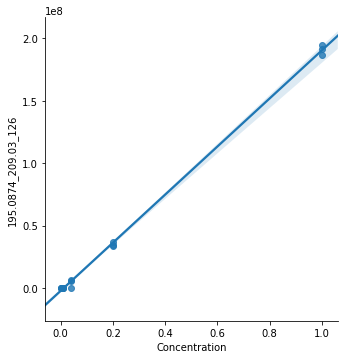

In [32]:
# Plot one feature
#OpenMS QT
sns.pairplot(dfa, x_vars='Concentration', y_vars='195.0874_209.03_126', size=5, aspect=1, kind='reg')

# Plot one feature
#OpenMS KD
#sns.pairplot(dfa, x_vars='Concentration', y_vars='279.0903_234.11_29', size=5, aspect=1, kind='reg')

In [33]:
print(dfa.shape)
print(dfa_id.shape)
dfa_id.head(10)

(15, 1031)
(15, 67)


,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,302.3043_399.31_8,782.5664_745.56_32,227.1752_98.71_62,110.0711_765.84_70,...,148.5642_281.46_705,316.3201_767.09_734,239.1638_460.81_764,305.1561_199.18_770,266.6083_438.51_783,178.5605_208.34_792,1001.6543_460.44_805,689.5583_770.5_823,414.7793_772.28_881,578.2764_427.82_988
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,1,C18_Polar_16,1637124.0,46867768.0,144504992.0,964380.5,...,3574551.0,0.0,3713782.0,6050232.0,2172881.0,3446559.0,1458548.0,0.0,0.0,0.0
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,2,C18_Polar_16,1150960.0,111018400.0,149036096.0,632997.1875,...,4772150.0,0.0,4157267.0,4743121.0,2262053.0,3321335.0,2250720.0,14713870.0,0.0,0.0
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.000,1,3,C18_Polar_16,9843772.0,90383800.0,139826304.0,566200.5,...,4116126.0,0.0,0.0,0.0,0.0,0.0,0.0,14857360.0,0.0,2366715.0
3,L_C18_Polar_16_MS2_DF_125_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,1,C18_Polar_16,9902876.0,0.0,43303008.0,47152408.0,...,0.0,3284784.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,L_C18_Polar_16_MS2_DF_125_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,2,C18_Polar_16,1463741.0,19870730.0,44049808.0,21544710.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,L_C18_Polar_16_MS2_DF_125_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,3,C18_Polar_16,10149860.0,28154210.0,39848288.0,24707790.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,L_C18_Polar_16_MS2_DF_25_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,1,C18_Polar_16,1418050.0,0.0,10435820.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,L_C18_Polar_16_MS2_DF_25_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,2,C18_Polar_16,11124140.0,6427834.0,10899440.0,35512648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,L_C18_Polar_16_MS2_DF_25_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.040,25,3,C18_Polar_16,1484570.0,10424310.0,10720530.0,35955560.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,L_C18_Polar_16_MS2_DF_5_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.200,5,1,C18_Polar_16,1251566.0,0.0,12657430.0,1503822.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Change the type of table
dfa_id[dfa_id.columns[6:]] = dfa_id[dfa_id.columns[6:]].apply(pd.to_numeric)
dfa_id[['Concentration','Dilution']] = dfa_id[['Concentration','Dilution']].apply(pd.to_numeric)

## Compute the linear regression for the FBMN - only for annotations


In [35]:
# create X and y
feature_cols = dfa_id.columns[6:]

X = dfa_id[feature_cols]
y = dfa_id.Concentration

In [36]:
# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print lm.intercept_
print lm.coef_

0.0011174602163951664
[ 1.46579906e-10 -3.91297481e-12  5.37012369e-10 -3.62030170e-10
 -5.26068204e-10  2.69833201e-09 -3.13680941e-10 -2.01221977e-09
  6.05292343e-10  1.60390200e-09  3.07957431e-09  4.48500624e-10
  1.69327146e-09  7.48385702e-10 -1.03808414e-11  4.57647825e-09
  2.20698526e-09  1.67202368e-09  6.92412117e-10  1.78139965e-09
 -2.41076667e-10 -1.05109465e-09  4.50570852e-10  5.44906402e-10
  3.15912071e-11  5.31671105e-11  2.21948995e-10 -1.55253512e-09
  1.11008276e-09  1.70609001e-11 -1.34926902e-10 -3.83225875e-11
  3.81387179e-11 -6.29660578e-11  2.26968157e-11 -7.64950917e-10
  3.71481002e-10  1.71054227e-10  1.29406059e-10  2.73473840e-11
 -2.63759711e-11 -2.26258449e-10  7.81616472e-11 -3.00160017e-11
  5.23820939e-11  2.18545135e-10  8.95926076e-13 -1.24497145e-10
  1.26003121e-12 -9.43409150e-11 -2.13859814e-11 -5.10817027e-11
  1.65538388e-10  1.11498130e-11  1.64638915e-10  1.88143066e-11
  4.90876848e-11 -4.02212771e-11 -1.08422715e-09  0.00000000e+00
 -3

In [37]:
#For loop to compute the r-squared

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols:
    model = LinearRegression()
    X, y = dfa_id[[x]], dfa_id.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.007258082760891349,
 0.003242912153411215,
 0.877317351619237,
 0.14210828161598998,
 0.004884895554248314]

In [38]:
# Prepare the new table
df_id_correlation_FMN = pd.DataFrame([x for x in liste2],columns=['r_square_FMN'])
df_id_coef_FMN = pd.DataFrame([x for x in liste3],columns=['coef_FMN'])
df_id_feature_FMN = pd.DataFrame([x for x in liste2_x],columns=['Feature_FMN'])
df_id_feature_FMN['r_square_FMN']= df_id_correlation_FMN['r_square_FMN']
df_id_feature_FMN['coef_FMN']= df_id_coef_FMN['coef_FMN']
df_id_feature_FMN = df_id_feature_FMN.set_index('Feature_FMN')
df_id_feature_FMN = df_id_feature_FMN.sort_values(by=['r_square_FMN'], ascending=True)

print(df_id_feature_FMN.shape)
yo = df_id_feature_FMN.shape[0]
df_id_feature_FMN = df_id_feature_FMN[df_id_feature_FMN['coef_FMN'] > 0]
df_id_feature_FMN.head(25)
print(df_id_feature_FMN.shape)
yo2 = df_id_feature_FMN.shape[0] 

print('This is the number of annotated features with negative coef (probably from the background)')
print(yo-yo2)
# We assume these features are from the background
df_id_feature_FMN.tail(15)

(61, 2)
(54, 2)
This is the number of annotated features with negative coef (probably from the background)
7


,r_square_FMN,coef_FMN
Feature_FMN,,
669.4935_559.16_461,0.943947,2.578567e-07
148.5642_281.46_705,0.947768,2.218426e-07
540.3052_425.31_548,0.951347,7.047095e-08
325.1704_310.92_472,0.953903,2.821400e-07
140.068_16.49_304,0.955220,4.108886e-09
432.28_238.8_419,0.960145,2.153924e-07
507.2365_241.07_617,0.960311,7.851782e-07
790.1593_262.22_636,0.961412,6.927639e-07
578.4413_30.79_305,0.963119,1.519150e-07


In [39]:
#Get the mean value for the r-squared
print reduce(lambda x, y: x + y, df_id_feature_FMN['r_square_FMN']) / len(df_id_feature_FMN['r_square_FMN'])
print reduce(lambda x, y: x + y, df_id_feature_FMN['coef_FMN']) / len(df_id_feature_FMN['coef_FMN'])

0.715310969105
1.74400734723e-07


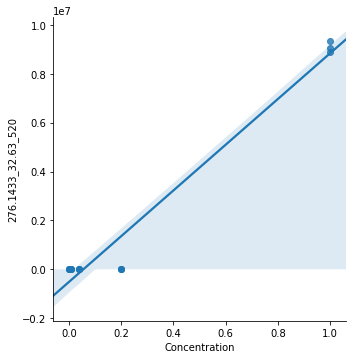

In [40]:
#OpenMS QT
sns.pairplot(dfa_id, x_vars='Concentration', y_vars='276.1433_32.63_520', size=5, aspect=1, kind='reg')

#OpenMS KD
#sns.pairplot(dfa_id, x_vars='Concentration', y_vars='205.097_99.4_50', size=5, aspect=1, kind='reg')

## VISUALISE

## Feature based molecular networking - All features r-squared

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


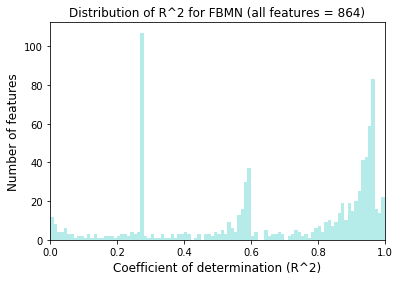

In [41]:
p2=sns.distplot(df_feature_FMN['r_square_FMN'], bins=100, hist = True, kde = False, color = 'mediumturquoise')
p2.set(xlim=(0, 1))

plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for FBMN (all features = '+str(df_feature_FMN.shape[0])+')')
plt.savefig('IMG_OpenMS/FBMN_allfeatures.png', dpi=500)
plt.savefig('IMG_OpenMS/FBMN_allfeatures.svg')

## Feature based molecular networking - Annotations only

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


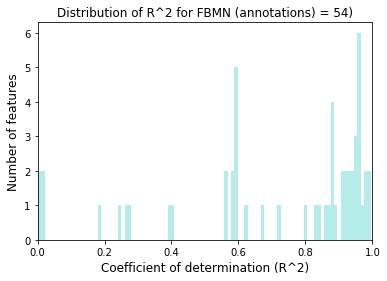

In [42]:
p3=sns.distplot(df_id_feature_FMN['r_square_FMN'], bins=100, hist = True, kde = False, color = 'mediumturquoise')
p3.set(xlim=(0, 1))
plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for FBMN (annotations) = '+str(df_id_feature_FMN.shape[0])+')')
plt.savefig('IMG_OpenMS/FBMN_annotations.png', dpi=500)
plt.savefig('IMG_OpenMS/FBMN_annotations.svg', dpi=500)